# CAPM Data Project

First, we import the relevant packages, including the Yahoo Finance library, which allows us to fetch historical market data, and the API of Statsmodel, which is used for statistical modeling including regression models, time series analysis etc.

In [1]:
# Install yfinance package
#%pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

from dataproject import *

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data

## 1.1 Importing data

In this section, we import the monthly stock data from Yahoo Finance for Miscrosoft, Novo Nordisk and Tesla, ranging from December 2019 to April 2024. We only import the Adjusted Close, which is the closing stock price, adjusted for corporate actions such as dividend payments or stock splits.

Further, we calculate the monthly returns for the three stocks, cleaning the data with dropna() by removing the December 2019 rows which has missing data for percentage changes due to a lack of a preceding month's data.

In [3]:
# Importing monthly stock data from Yahoo Finance
data = yf.download(["MSFT", "NVO", "TSLA"], start = "2019-12-01", end = "2024-04-11", interval = "1mo")
data = data['Adj Close'] # Only look at the adjusted close stock price

# Calculate monthly returns
data["MSFT_returns"] = data["MSFT"].pct_change() * 100
data["NVO_returns"] = data["NVO"].pct_change() * 100
data["TSLA_returns"] = data["TSLA"].pct_change() * 100
data = data.dropna() # Drops 2019-12-01 which is NA

print(data.head())

[*********************100%%**********************]  3 of 3 completed

Ticker            MSFT        NVO       TSLA  MSFT_returns  NVO_returns  \
Date                                                                      
2020-01-01  163.737289  28.578434  43.371334      7.945486     5.096747   
2020-02-01  155.830795  27.309950  44.532665     -4.828768    -4.438606   
2020-03-01  152.109177  28.282454  34.933334     -2.388243     3.560987   
2020-04-01  172.845627  29.752951  52.125332     13.632610     5.199327   
2020-05-01  176.742142  30.979153  55.666668      2.254332     4.121279   

Ticker      TSLA_returns  
Date                      
2020-01-01     55.515986  
2020-02-01      2.677647  
2020-03-01    -21.555707  
2020-04-01     49.213732  
2020-05-01      6.793887  


## 1.2 Merging with Fama-French

In this section, we load the data with the market return and the risk free return from the Fama-French dataset. We define the first column of the dataframe as "Date" and setting it as the index, so we can match it and merge it later on with the stock data from 1.2. 

In [4]:
# Load Data with market return and risk free return from Fama-French
df = pd.read_excel('Fama-French.xlsx')
df.columns = ['Date'] + list(df.columns[1:]) # Name first column Date
df.set_index("Date", inplace=True) # Set the date column as the index
print(df.head())

        Mkt-RF    RF
Date                
192607    2.96  0.22
192608    2.64  0.25
192609    0.36  0.23
192610   -3.24  0.32
192611    2.53  0.31


We change the format of the index to YYYY-MM-DD such that it matches the stock dataframe.
The return_df dataframe creates a new dataframe from the existing 'data' dataframe, selecting all rows but only the columns starting from the fourth column (index 3), such that the return_df is a dataframe with only the calculated returns.

We then merge 'return_df' with 'df' based in their indexes. The 'left_index' and 'right_index' parameters set to 'True' indicate that the merge should be done based on the df indexes. The 'how='inner' parameter specifices that the merge should be an inner join, meaning only those dates that appear in both DataFrames will be included in 'merged_data'. If the dates do not appear in both dataframes, the row does not merge.


In [5]:
# Change the format of the index from YYYYDD to YYYY-MM-DD
df.index = pd.to_datetime(df.index, format='%Y%m')

# Create dataframe with returns
return_df = data.iloc[:, 3:] 

# Inner merge the dataframes on the dates
merged_data = return_df.merge(df, left_index=True, right_index=True, how='inner')

# Print the first few rows of the merged dataframe to verify
print(merged_data.head())

            MSFT_returns  NVO_returns  TSLA_returns  Mkt-RF    RF
Date                                                             
2020-01-01      7.945486     5.096747     55.515986   -0.11  0.13
2020-02-01     -4.828768    -4.438606      2.677647   -8.13  0.12
2020-03-01     -2.388243     3.560987    -21.555707  -13.39  0.13
2020-04-01     13.632610     5.199327     49.213732   13.65  0.00
2020-05-01      2.254332     4.121279      6.793887    5.58  0.01


We now loop over each column in the return_df dataframe, creating 3 new columns which calculates the stock return minus the risk free return and adding it to the merged_data dataset, naming it the column name + '-RF'.

In [6]:
# Loop over the columns to create new column with the stock return minus the risk free return
for column in return_df.columns:
    merged_data[column + '-RF'] = merged_data[column] - merged_data['RF']

print(merged_data.head())


            MSFT_returns  NVO_returns  TSLA_returns  Mkt-RF    RF  \
Date                                                                
2020-01-01      7.945486     5.096747     55.515986   -0.11  0.13   
2020-02-01     -4.828768    -4.438606      2.677647   -8.13  0.12   
2020-03-01     -2.388243     3.560987    -21.555707  -13.39  0.13   
2020-04-01     13.632610     5.199327     49.213732   13.65  0.00   
2020-05-01      2.254332     4.121279      6.793887    5.58  0.01   

            MSFT_returns-RF  NVO_returns-RF  TSLA_returns-RF  
Date                                                          
2020-01-01         7.815486        4.966747        55.385986  
2020-02-01        -4.948768       -4.558606         2.557647  
2020-03-01        -2.518243        3.430987       -21.685707  
2020-04-01        13.632610        5.199327        49.213732  
2020-05-01         2.244332        4.111279         6.783887  


# 2 Regression

First we create an independent variable X by selecting the "Mkt-RF" column from merged_data. By writing add_constant, we add a constant column to X, which acts as the intercept in the regression model. The 'Mkt-RF' column represents the excess market returns, i.e. the market returns minus the risk-free rate. 

The for loop iterates over each column in merged_data, starting from the sixth column. The loop does the following, for example for column 6, MSFT_returns-RF: 
1) We define the column for MSFT_returns-RF as the dependent variable.
2) We use the statsmodel package to do an OLS regression, regressing y on x, excluding potential nan.values.
3) Thereafter, the regression model is fitted, and the results are stored in the dictionary 'results', keyed by the column name of the stock return.


In [7]:
# Prepare the explanatory variable (Excess market returns), adding a constant for the intercept
X = sm.add_constant(merged_data['Mkt-RF'])

# Loop through each stock return column and perform regression
results = {}
for return_col in merged_data.iloc[:, 5:]:
    # Prepare the dependent variable
    y = merged_data[return_col]  # Dependent variable (stock excess returns)

    # Fit the regression model
    model = sm.OLS(y, X, missing='drop')  # OLS regression, excluding potential NaN values
    results[return_col] = model.fit()

    # Print the summary of the regression results
    #print(f"Regression Results for {return_col}:\n")
    #print(results[return_col].summary())
    #print("\n\n")


We now call the beta_table function from dataproject.py. 

We note that, to use this function, we have to have a 'results' table already, containing key-value pairs, where the key is the name of the object and each value is a regression result object such as beta or a t-statistic.

The function does the following:

1) Extracts and rounds the 'Mkt-rf' beta coefficient and stores it in beta_values, extracts and rounds the constant term and stores it in constant_values
2) Calculates the t-values for the 'Mkt-rf' coefficient by dividing the beta coefficient by its standard error, storing it in t_values. Same method for the t-values for the constant term, storing it in t_values_a.

3) Having the values, the function constructs a dataframe with columns 'Stock', 'Beta', 't_Beta, 'cons', 't_cons', returning the dataframe.

Now, we call the beta_table function, printing the beta_table:

In [8]:
Dataproject.beta_table(results)

,Stock,Beta,t_Beta,cons,t_cons
0,MSFT_returns-RF,0.816,7.04,1.246,1.84
1,NVO_returns-RF,0.350,2.48,2.659,3.23
2,TSLA_returns-RF,2.471,5.38,3.706,1.38


We find that Novo Nordisk has the lowest correlation with the market, followed by Microsoft and then Tesla. All beta coefficients are significant on a 5% significance level.

# 3 Portfolios
We illustrate the Efficient Market Frontier from the CAPM. We first find the two portfolios of interest, which are the Minimum Variance Portfolio and the Efficient Tangent Portfolio. These are the portfolios with the lowest possible variance and the portfolio with the highest return relative to its risk respectively. 

## 3.1 Return and covariance matrix
We first create the average return matrix and the covariance matrix for our selected stocks.

In [9]:
# Keep returns of Novo, Microsoft and Tesla
returns = data.iloc[:,3:]

# Calculate the average return over the period
return_matrix = np.mean(returns, axis = 0)
print(return_matrix)

Ticker
MSFT_returns    2.190104
NVO_returns     3.142030
TSLA_returns    5.845781
dtype: float64


In [22]:
# Calculate covariance matrix
cov_matrix = returns.cov()
print(cov_matrix)

# Calculates volatilities
volatility_matrix = np.sqrt(np.var(returns, axis=0, ddof=1))

Ticker        MSFT_returns  NVO_returns  TSLA_returns
Ticker                                               
MSFT_returns     42.549130    20.273096     83.367883
NVO_returns      20.273096    36.103378     -1.203844
TSLA_returns     83.367883    -1.203844    531.660423


We create a portfolio function. The function calculates the expected return and volatility of any portfolio for given weights of the three stocks.

In [23]:
# Define portfolio function, which returns ER and Volatility for any portfolio weights W
def portfolio(w1, w2, return_matrix=return_matrix, cov_matrix=cov_matrix): 
    '''Calculate expected return and volatility for given portfolio'''

    index = return_matrix.index # Get index of return matrix
    W = pd.DataFrame([w1,w2, 1-w1-w2], index=index) # Set weights to have matching index with returns
    tW = W.transpose() # Transposed weight matrix

    var = tW.dot(cov_matrix).dot(W) # Formula for calculating variance
    sd = np.sqrt(var)[0][0] # Calculates volatility

    e_r = tW.dot(return_matrix)[0] # Formula for expected return

    return e_r, sd

## 3.2 Minimum Variance Portfolio
Below we find the Minimum Variance Portfolio. To illustrate the result we plot the volatility as a function of the weights.

In [24]:
# Call Data project class
capm = Dataproject

# Calculate minimum variance portfolio by using mvp_w, which minimizes the variance for given portfolio of stocks
w1_min, w2_min, min_vol = capm.mvp_w(portfolio)
mvp = portfolio(w1_min, w2_min)

print(f'Minimum variance weights: w1 = {w1_min:.3f}, w2 = {w2_min:.3f}, w3 = {1-w1_min-w2_min:.3f}')
print(f'MVP return = {mvp[0]:.3f}, MVP SD = {mvp[1]:.3f}')


Minimum variance weights: w1 = 0.453, w2 = 0.561, w3 = -0.015
MVP return = 2.671, MVP SD = 5.428


The minimum variance portfolio consistents of longen just about half in Microsoft and Novo and slightly shorting Tesla, this makes sense because Tesla has by far the biggest variance as seen in the covariance matrix, so you want a low weight in your portfolio. '

The MVP has a monthly return of 2.6% and a volatility of 5.43. 

Below we illustrate that we have indeed found the minimum variance portfolio. We show 3 plots with varying weights as well as the weights and return of the minimum variance portfolio. The portfolio function has two inputs, so to keep the plot 2-dimensional rather than 3-d, we hold w2 semi-fixed. We create 3 plots, one where w2 is set to w2_min and two others where w2 is changed by $\pm$ delta. 

As such, w1 is fixed, w2 is held fixed for a given value of delta and w3 is residually calculated (w3=1-w1-w2).

In [25]:
%matplotlib inline
import ipywidgets as widgets

# Interactive widget showing volatility where w2 is held semi-fixed, to preserve 1-d plot
widgets.interact(
    capm.plot_variance,
    portfolio=widgets.fixed(portfolio),
    mvp_w=widgets.fixed(capm.mvp_w),
delta=widgets.FloatSlider(min=0, max=0.5, step=0.1, value = 0.3),
)

interactive(children=(FloatSlider(value=0.3, description='delta', max=0.5), Output()), _dom_classes=('widget-i…

<function dataproject.Dataproject.plot_variance(portfolio, mvp_w, delta=0.5)>

We see from the plot the minimum that we found coincides with the graphs. This at least shows that w1_min is correct, but we also see as we change w2_min by delta, then the minima of the graphs increase, which shows that w2_min is also correct, and we indeed have found the minimum variance weights.

## 3.2 Efficient Tangent Portfolio
To calculate the efficient tangent portfolio we draw from the CAPM theory, which says that the ETP has the highest sharpe ratio, that is the highest excess return relative to its volatility. We therefore have a function which can calculate the sharpe ratio, and we will find the ETP weights by maximizing this function. 

In [27]:
def sharpe_ratio(w1, w2, portfolio=portfolio, rf = 0):
    '''Calculate the sharpe ratio for any portfolio'''

    rf = rf # Risk free rate
    e_r, sd = portfolio(w1, w2) # Expected return and volatility

    sharpe = (e_r - rf)/sd # Calculates Sharpe ratio
    return sharpe

We assume that the risk free rate is constant and set it equal to the mean of the risk free return from the Fama-French dataset.

In [28]:
rf_mean = np.mean(df["RF"])

We found the ETP weights by maximizing the sharpe ratio using the etp_w function, which find the portfolio which has the highest Sharpe ratio.

In [29]:
w1_etp, w2_etp, etp_sharp = capm.etp_w(sharpe_ratio, rf=rf_mean) # Weights that maximize the Sharpe ratio
etp = portfolio(w1_etp, w2_etp)

print(f'Efficient tangent portfolio weights: w1 = {w1_etp:.3f}, w2 = {w2_etp:.3f} and w3 = {1-w1_etp-w2_etp:.3f}\n')
print(f'ETP return = {etp[0]:.3f}, ETP SD = {etp[1]:.3f}, ETP Sharpe Ratio = {etp_sharp:.3f}')

Efficient tangent portfolio weights: w1 = -0.402, w2 = 1.208 and w3 = 0.194

ETP return = 4.051, ETP SD = 6.808, ETP Sharpe Ratio = 0.556


The Efficient Tangent Portfolio shorts microsoft and longs Novo heavily while also having some in Tesla. The ETP has a return of 4% per month and a volatility of 6.8, both of which are larger than the MVP as expected.

Below we plot the sharpe ratio as a function the weight on Microsoft, w1, and again to keep the plot 2-dimensional we hold w2 semi-fixed around w2_etp. 

In [17]:
%matplotlib inline

widgets.interact(
    capm.plot_sharp,
    sharpe_ratio=widgets.fixed(sharpe_ratio),
    etp_w = widgets.fixed(capm.etp_w),
    rf=widgets.fixed(rf_mean),
delta=widgets.FloatSlider(min=0, max=0.6, step=0.2, value = 0.4),
)

interactive(children=(FloatSlider(value=0.4, description='delta', max=0.6, step=0.2), Output()), _dom_classes=…

<function dataproject.Dataproject.plot_sharp(sharpe_ratio, etp_w, rf, delta=0.5)>

The plot shows that we have found the correct maximum as the point is at the peak of the sharpe ratio function, and the peaks are lower for the other functions where w2_etp is changed by delta.

## 3.3 Efficient market frontier
The mutual fund theorem of the CAPM says that any linear combination of any two portfolios which are efficient will also be efficient. Therefore we can create the efficient market frontier by taking linear combinations of the minimum variance portfolio and efficient tangent portfolio which we know are efficient. We will then plot all the different portfolio.

In [30]:
# Weights for the MVP and ETP
mvp_weights = pd.DataFrame([w1_min, w2_min, 1 - w1_min - w2_min])
etp_weights = pd.DataFrame([w1_etp, w2_etp, 1 - w1_etp - w2_etp])

# Creating y_vec and lin_vec to store linear combinations
y_vec = np.linspace(-3, 3, 100)
lin_vec = []

for y in y_vec:
    linear = y*mvp_weights + (1-y)*etp_weights
    lin_vec.append(linear[0][0:2])

Plotting the efficient market frontier and the capital market line by calling plot_capm.

__Explanation of the plot_capm function:__

1. First, a figure and an axis are created for plotting.

2. Next, an empty list to store points of the efficient frontier is created. 

3. A loop iterates over 'lin_vec', and for each element in lin_vec, we call the portfolio function defined in section 3.1 to compute portfolio returns and volatilities. These values are then appended to "frontier". Lastly for this part, we unpack(unzip) the frontier and put them into the lists 'return_values' and 'vol_values'. We now have values for the efficient frontier, which shows the highest return given a level of risk.

4. rf = rf, point_rf = [0,rf] and point_etp = [etp[1], etp[0]] defines the points for the risk-free rate and the ETP. By definition, risk-free rate is the risk-free return you can get at zero variance, so it is the y-intercept. The point for ETP is the point where the ETP intersects the Capital Market line.

5. Next, we calculate the slope and the y-intercept of the capital market line, using the points for the riskfree rate and the etp. 

6. x and corresponding y values for the capital market line are calculated and we plot the capital market line.

7. Lastly, we plot everything. We plot the efficient frontier, using the values defined in 3. (return_values and vol_values), we plot the points for  MVP and the ETP, marking it with green and red, we plot the point for the risk-free return. Further, we plot the stocks for NVO, MSFT and TSLA, annotate the text, set labels and add a legend.

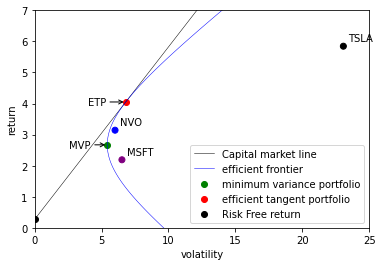

In [35]:
capm.plot_capm(mvp, etp, rf_mean, lin_vec, portfolio, return_matrix, volatility_matrix, data)

Here we have plotted the efficient market frontier with the 3 stocks, the MVP and the ETP. We see as expected, that the minimum variance portfolio is the portfolio which the lowest volatility and that the ETP is exactly tangential with the efficient frontier and the risk-free return. 